![](https://media.springernature.com/lw1200/springer-static/image/art%3A10.1186%2Fs12938-023-01113-y/MediaObjects/12938_2023_1113_Fig6_HTML.png)

# **Architecture Overview**
This model is a Spatial-Attention-based Encoder-Decoder. It moves beyond standard image classification by using a "Deep Vision" backbone paired with a "Context-Aware" linguistic decoder.
* The Encoder (Visual Memory):
  Uses ResNet50 to extract a (7x7) grid of features. This allows the model to preserve the location of medical findings (e.g., distinguishing  between the left and right lung).
* The Attention Bridge: Implements Bahdanau (Additive) Attention. At every word prediction, the model "scans" the (7x7) grid to decide which part of the X-ray is most relevant.
* The Decoder (Report Writer): A Bidirectional LSTM that takes the visual context and the previously generated words to predict the next clinical term.

# **Import Librarys**

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

2026-02-14 09:55:15.688700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771062915.871862      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771062915.926445      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771062916.343995      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771062916.344053      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771062916.344059      24 computation_placer.cc:177] computation placer alr

In [2]:
# --- CONFIGURATION ---
VOCAB_SIZE = 5000
MAX_LENGTH = 50  # Max words in a report
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 32
EMBEDDING_DIM = 256

# **Load Data**

In [3]:
path = "/kaggle/input/chest-xrays-indiana-university"

In [4]:
print(os.listdir(path))

['indiana_projections.csv', 'images', 'indiana_reports.csv']


In [5]:
import pandas as pd
import os

# Load the data
projections = pd.read_csv(os.path.join(path, 'indiana_projections.csv'))
reports = pd.read_csv(os.path.join(path, 'indiana_reports.csv'))

# Focus on Frontal view to simplify the initial model
frontal_projections = projections[projections['projection'] == 'Frontal']

# Merge reports with their corresponding frontal images
data = pd.merge(reports, frontal_projections, on='uid')

# Keep only the columns we need: image filename and the findings
# We fill empty findings with "normal" as many X-rays are clear
df = data[['filename', 'findings']].fillna('normal')

# Add start and end tokens for the LSTM
df['findings'] = df['findings'].apply(lambda x: f'startseq {x.lower()} endseq')

print(f"Total samples: {len(df)}")
display(df.head())

Total samples: 3818


,filename,findings
0,1_IM-0001-4001.dcm.png,startseq the cardiac silhouette and mediastinu...
1,2_IM-0652-1001.dcm.png,startseq borderline cardiomegaly. midline ster...
2,3_IM-1384-1001.dcm.png,startseq normal endseq
3,4_IM-2050-1001.dcm.png,startseq there are diffuse bilateral interstit...
4,5_IM-2117-1003002.dcm.png,startseq the cardiomediastinal silhouette and ...


In [6]:
image_dir = os.path.join(path, 'images')

# Create a dictionary for quick lookup of image paths
image_path_dict = {filename: os.path.join(image_dir, filename) for filename in df['filename']}

print(f"Number of images found: {len(image_path_dict)}")

Number of images found: 3818


In [7]:
import os
import pandas as pd

# Update this to your local kagglehub path
base_path = path
image_dir = os.path.join(base_path, 'images/images_normalized')

# Get a set of all actual filenames in the folder for O(1) lookup
actual_files = set(os.listdir(image_dir))

# Filter the dataframe to only include rows where the image exists
df_filtered = df[df['filename'].isin(actual_files)].copy()

# Create the full path mapping
image_path_dict = {fn: os.path.join(image_dir, fn) for fn in df_filtered['filename']}

print(f"Total images in folder: {len(actual_files)}")
print(f"Matches found in CSV: {len(df_filtered)}")

Total images in folder: 7470
Matches found in CSV: 3818


# **visualize Data**

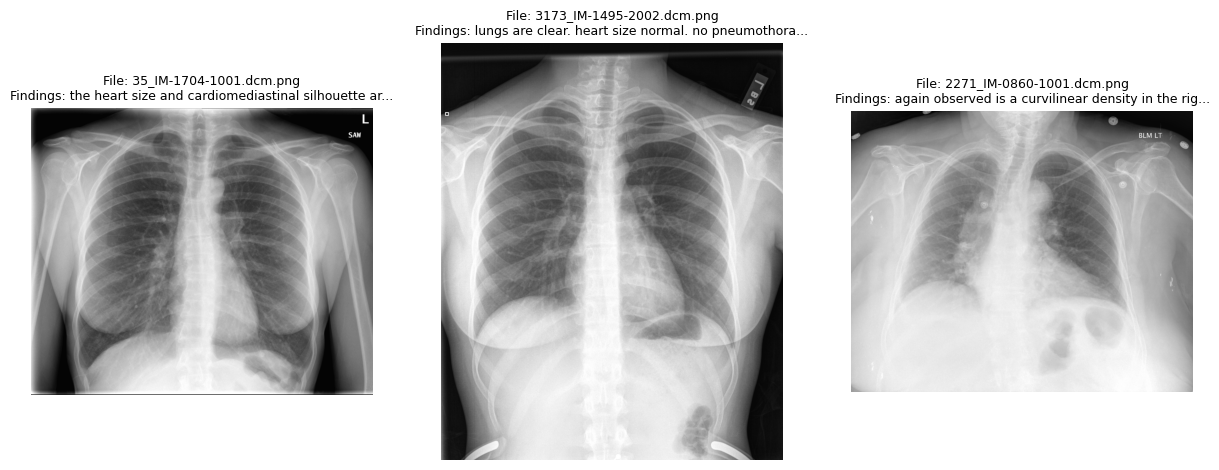

In [8]:
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import load_img

def show_valid_samples(dataframe, num_samples=3):
    indices = random.sample(range(len(dataframe)), num_samples)
    plt.figure(figsize=(15, 7))

    for i, idx in enumerate(indices):
        row = dataframe.iloc[idx]
        img_path = image_path_dict[row['filename']]

        img = load_img(img_path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap='gray')

        # Clean up text for display
        clean_text = row['findings'].replace('startseq', '').replace('endseq', '').strip()
        plt.title(f"File: {row['filename']}\nFindings: {clean_text[:50]}...", fontsize=9)
        plt.axis('off')

    plt.show()

show_valid_samples(df_filtered)

/tmp/ipykernel_24/114626187.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='word', data=word_freq_df, palette='viridis')


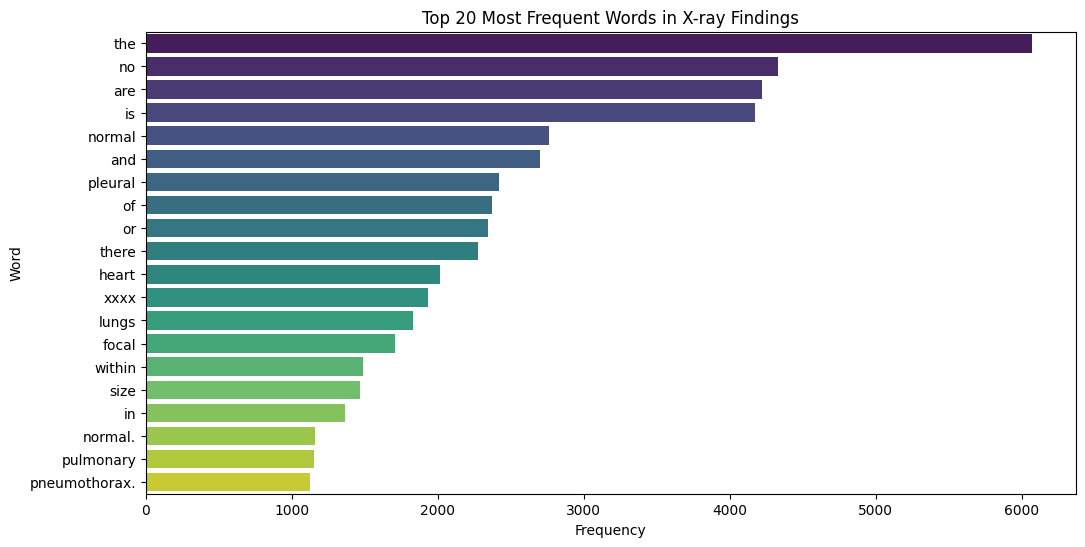

In [9]:
from collections import Counter
import seaborn as sns

# Combine all findings into a single string
all_findings = ' '.join(df_filtered['findings'])

# Tokenize the words and remove 'startseq' and 'endseq' and any single character words
words = [word for word in all_findings.split() if word not in ['startseq', 'endseq'] and len(word) > 1]

# Count word frequencies
word_counts = Counter(words)

# Get the most common words
most_common_words = word_counts.most_common(20) # Top 20 words

# Create a DataFrame for plotting
word_freq_df = pd.DataFrame(most_common_words, columns=['word', 'frequency'])

plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='word', data=word_freq_df, palette='viridis')
plt.title('Top 20 Most Frequent Words in X-ray Findings')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

# **Chest X-rays Image Captioning CNN(RseNet50) + RNN(LSTM)**

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, AdditiveAttention, Reshape, Concatenate, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_advanced_attention_model(vocab_size, max_length):
    # 1. Image Feature Input (Spatial features from ResNet)
    # Shape: (7, 7, 2048) allows the model to "look" at different parts of the X-ray
    image_input = Input(shape=(7, 7, 2048), name="image_spatial_input")
    
    # Flatten spatial dimensions to (49, 2048) for the attention mechanism
    feat_reshape = Reshape((49, 2048))(image_input)
    img_features = Dense(512, activation='relu')(feat_reshape)
    
    # 2. Text Input (Sequence of word indices)
    text_input = Input(shape=(max_length,), name="text_input")
    embedding = Embedding(vocab_size, 512, mask_zero=True)(text_input)
    
    # 3. Attention & LSTM
    # Bidirectional LSTM captures context from both directions of the report
    lstm_layer = Bidirectional(LSTM(256, return_sequences=True))(embedding)
    
    # Additive Attention (Bahdanau Style)
    # The LSTM query asks "where in the image should I look to predict the next word?"
    attention_out = AdditiveAttention()([lstm_layer, img_features])
    
    # Concatenate visual context with linguistic context
    merged = Concatenate()([lstm_layer, attention_out])
    
    # 4. Output Head
    dense_int = Dense(512, activation='relu')(merged)
    dense_int = Dropout(0.5)(dense_int)
    
    # Dense layer with Softmax to predict the probability of the next word in the vocab
    output = Dense(vocab_size, activation='softmax')(dense_int)

    # Instantiate the model
    model = Model(inputs=[image_input, text_input], outputs=output)
    
    # Compile with a slightly lower learning rate for stability in medical data
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=Adam(learning_rate=1e-4), 
        metrics=['accuracy']
    )
    return model

# --- CRITICAL FIX: Initialize the model variable ---
# Assuming VOCAB_SIZE and MAX_LENGTH were defined in your previous config cells
# We use +1 for the vocabulary size to account for the padding token (0)
model = build_advanced_attention_model(VOCAB_SIZE + 1, MAX_LENGTH)

# Now summary() will work
model.summary()

I0000 00:00:1771062931.263957      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_spatial_input │ (None, 7, 7,      │          0 │ -                 │
│ (InputLayer)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 512)   │  2,560,512 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 50)        │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 49, 2048)  │          0 │ image_spatial_in… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50, 512)   │  1,574,912 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 49, 512)   │  1,049,088 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention  │ (None, 50, 512)   │        512 │ bidirectional[0]… │
│ (AdditiveAttention) │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 50, 1024)  │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ additive_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 50, 512)   │    524,800 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50, 512)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 50, 5001)  │  2,565,513 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,275,337 (31.57 MB)

 Trainable params: 8,275,337 (31.57 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

def build_resnet_spatial_encoder():
    # include_top=False removes the final classification layers
    # This leaves us with the last convolutional layer output
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # We want the spatial output (None, 7, 7, 2048) 
    # This represents a 7x7 grid of the image, each cell having 2048 features
    return Model(inputs=base_model.input, outputs=base_model.output)

# Initialize the encoder
spatial_encoder = build_resnet_spatial_encoder()

def get_spatial_features(image_path):
    # 1. Load and resize the X-ray
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    
    # 2. Expand dimensions for batch size (1, 224, 224, 3)
    img = np.expand_dims(img, axis=0)
    
    # 3. Preprocess using ResNet50's specific requirements (Caffe/Torch style)
    img = preprocess_input(img)
    
    # 4. Predict and return the (7, 7, 2048) feature map
    # Using [0] to remove the batch dimension
    feature_map = spatial_encoder.predict(img, verbose=0)[0]
    return feature_map

print("Spatial Encoder ready. Feature map shape:", spatial_encoder.output_shape)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Spatial Encoder ready. Feature map shape: (None, 7, 7, 2048)


In [12]:
import numpy as np

print("Extracting spatial features (7, 7, 2048)...")
# This may take a few minutes depending on your GPU/CPU
spatial_features_dict = {}

for _, row in df_filtered.iterrows():
    img_path = image_path_dict[row['filename']]
    # Use the get_spatial_features function we defined earlier
    feat = get_spatial_features(img_path) 
    spatial_features_dict[row['filename']] = feat

print(f"Features extracted for {len(spatial_features_dict)} images.")

Extracting spatial features (7, 7, 2048)...


I0000 00:00:1771062936.448270      68 service.cc:152] XLA service 0x13bdd8f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771062936.448313      68 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771062937.222439      68 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1771062939.582221      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Features extracted for 3818 images.


In [13]:
def spatial_data_generator(df, features_dict, tokenizer, max_length, vocab_size, batch_size):
    while True:
        df_shuffled = df.sample(frac=1).reset_index(drop=True)
        X_img, X_txt, y = [], [], []

        for _, row in df_shuffled.iterrows():
            if row['filename'] not in features_dict:
                continue

            img_feat = features_dict[row['filename']] # Shape: (7, 7, 2048)
            seq = tokenizer.texts_to_sequences([row['findings']])[0]

            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                X_img.append(img_feat)
                X_txt.append(in_seq)
                y.append(out_seq)

                if len(X_img) == batch_size:
                    # Yielding as (Inputs, Targets)
                    yield ({"image_spatial_input": np.array(X_img), "text_input": np.array(X_txt)}, np.array(y))
                    X_img, X_txt, y = [], [], []

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf

# 1. Re-initialize and fit the Tokenizer
# We use <unk> for words not in our top 5000 to keep the model robust
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<unk>", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(df_filtered['findings'])

# Define the actual vocab size (Word count + 1 for padding)
actual_vocab_size = len(tokenizer.word_index) + 1
print(f"Tokenizer vocabulary size: {actual_vocab_size}")

# 2. Split the data
train_df, val_df = train_test_split(df_filtered, test_size=0.1, random_state=42)

# 3. Create Train Dataset using the spatial_data_generator
train_dataset = tf.data.Dataset.from_generator(
    lambda: spatial_data_generator(train_df, spatial_features_dict, tokenizer, MAX_LENGTH, actual_vocab_size, BATCH_SIZE),
    output_signature=(
        ({"image_spatial_input": tf.TensorSpec(shape=(None, 7, 7, 2048), dtype=tf.float32),
          "text_input": tf.TensorSpec(shape=(None, MAX_LENGTH), dtype=tf.int32)},
         tf.TensorSpec(shape=(None, actual_vocab_size), dtype=tf.float32))
    )
).prefetch(tf.data.AUTOTUNE)

# 4. Create Validation Dataset
val_gen = tf.data.Dataset.from_generator(
    lambda: spatial_data_generator(val_df, spatial_features_dict, tokenizer, MAX_LENGTH, actual_vocab_size, BATCH_SIZE),
    output_signature=(
        ({"image_spatial_input": tf.TensorSpec(shape=(None, 7, 7, 2048), dtype=tf.float32),
          "text_input": tf.TensorSpec(shape=(None, MAX_LENGTH), dtype=tf.int32)},
         tf.TensorSpec(shape=(None, actual_vocab_size), dtype=tf.float32))
    )
).prefetch(tf.data.AUTOTUNE)

print("Tokenizer, train_dataset, and val_gen are now defined and ready.")

Tokenizer vocabulary size: 1590
Tokenizer, train_dataset, and val_gen are now defined and ready.


In [15]:
# --- CONFIGURATION ---
# We estimate the average number of word-pairs per report to be around 15-20
# for the Indiana University dataset.
AVG_WORDS_PER_REPORT = 20 

# Total training samples = (Number of reports) * (Avg samples per report)
total_train_samples = len(train_df) * AVG_WORDS_PER_REPORT
total_val_samples = len(val_df) * AVG_WORDS_PER_REPORT

# steps_per_epoch = total samples / batch size
steps_per_epoch_train = total_train_samples // BATCH_SIZE
steps_per_epoch_val = total_val_samples // BATCH_SIZE

print(f"Training steps per epoch: {steps_per_epoch_train}")
print(f"Validation steps per epoch: {steps_per_epoch_val}")

# Safety check: ensure they are at least 1
steps_per_epoch_train = max(1, steps_per_epoch_train)
steps_per_epoch_val = max(1, steps_per_epoch_val)

Training steps per epoch: 2147
Validation steps per epoch: 238


In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, AdditiveAttention, Reshape, Concatenate, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

def build_advanced_attention_model(vocab_size, max_length):
    # 1. Image Spatial Input (The 7x7 grid from ResNet)
    image_input = Input(shape=(7, 7, 2048), name="image_spatial_input")
    feat_reshape = Reshape((49, 2048))(image_input)
    img_features = Dense(512, activation='relu')(feat_reshape)
    
    # 2. Text Input (The partial report sequence)
    text_input = Input(shape=(max_length,), name="text_input")
    embedding = Embedding(vocab_size, 512, mask_zero=True)(text_input)
    
    # Bi-LSTM to understand the text context generated so far
    lstm_layer = Bidirectional(LSTM(256, return_sequences=False))(embedding)
    
    # 3. Attention Mechanism
    # Reshape LSTM output to (Batch, 1, 512) to serve as a 'query' for attention
    query = Reshape((1, 512))(lstm_layer)
    
    # AdditiveAttention (Bahdanau) matches the query against image spatial features
    attention_out = AdditiveAttention()([query, img_features])
    
    # Reshape back to (Batch, 512)
    attention_out = Reshape((512,))(attention_out)
    
    # 4. Merge Visual & Textual info
    merged = Concatenate()([lstm_layer, attention_out])
    dense_int = Dense(512, activation='relu')(merged)
    dense_int = Dropout(0.5)(dense_int)
    
    # Predict the next word in the vocabulary
    output = Dense(vocab_size, activation='softmax')(dense_int)

    model = Model(inputs=[image_input, text_input], outputs=output)
    return model

# Ensure VOCAB_SIZE and MAX_LENGTH are used from your config
# We use actual_vocab_size to match your tokenizer exactly
model = build_advanced_attention_model(actual_vocab_size, MAX_LENGTH)

# Compile with label smoothing for clinical variety
model.compile(
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=Adam(learning_rate=3e-4),
    metrics=['accuracy']
)

print("Model successfully compiled and ready for training.")
model.summary()

Model successfully compiled and ready for training.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 50, 512)   │    814,080 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 50)        │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_spatial_input │ (None, 7, 7,      │          0 │ -                 │
│ (InputLayer)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 512)       │  1,574,912 │ embedding_1[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 49, 2048)  │          0 │ image_spatial_in… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 512)    │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 49, 512)   │  1,049,088 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention… │ (None, 1, 512)    │        512 │ reshape_2[0][0],  │
│ (AdditiveAttention) │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 512)       │          0 │ additive_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 1024)      │          0 │ bidirectional_1[… │
│ (Concatenate)       │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │    524,800 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1590)      │    815,670 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,779,062 (18.23 MB)

 Trainable params: 4,779,062 (18.23 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy

# 1. Compile with Label Smoothing
# Label smoothing (0.1) is vital for medical text to prevent the model 
# from overfitting on the repetitive "normal" phrases.
model.compile(
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=Adam(learning_rate=3e-4),
    metrics=['accuracy']
)

# 2. Define Callbacks
# ReduceLROnPlateau helps the model "fine-tune" once progress plateaus.
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    min_lr=1e-6, 
    verbose=1
)

# Early stopping prevents wasting time once the model stops improving.
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=7, 
    restore_best_weights=True
)

# Save the best version of your attention-based model.
checkpoint = ModelCheckpoint(
    'best_attention_model.keras', 
    monitor='val_accuracy', 
    save_best_only=True
)

# 3. Training execution
# Note: Ensure train_dataset and val_gen have been recreated 
# to yield (7, 7, 2048) image features!
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_gen,
    callbacks=[lr_scheduler, early_stop, checkpoint],
    steps_per_epoch=steps_per_epoch_train,
    validation_steps=steps_per_epoch_val
)

Epoch 1/30
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 47s 20ms/step - accuracy: 0.1603 - loss: 5.0022 - val_accuracy: 0.4514 - val_loss: 3.4029 - learning_rate: 3.0000e-04
Epoch 2/30
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 43s 20ms/step - accuracy: 0.4484 - loss: 3.4464 - val_accuracy: 0.5381 - val_loss: 3.0234 - learning_rate: 3.0000e-04
Epoch 3/30
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 43s 20ms/step - accuracy: 0.5173 - loss: 3.1150 - val_accuracy: 0.5663 - val_loss: 2.8440 - learning_rate: 3.0000e-04
Epoch 4/30
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - accuracy: 0.5580 - loss: 2.9258 - val_accuracy: 0.5857 - val_loss: 2.7751 - learning_rate: 3.0000e-04
Epoch 5/30
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - accuracy: 0.5814 - loss: 2.7941 - val_accuracy: 0.6048 - val_loss: 2.7124 - learning_rate: 3.0000e-04
Epoch 6/30
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - accuracy: 0.5996 - loss: 2.7331 - val_accuracy: 0.6124 - val_loss: 2.6612 - learning_rate: 3.0000e-04
Epoch 7/30
2147/2147 ━━━━━━━━━━━━━━━━━━━

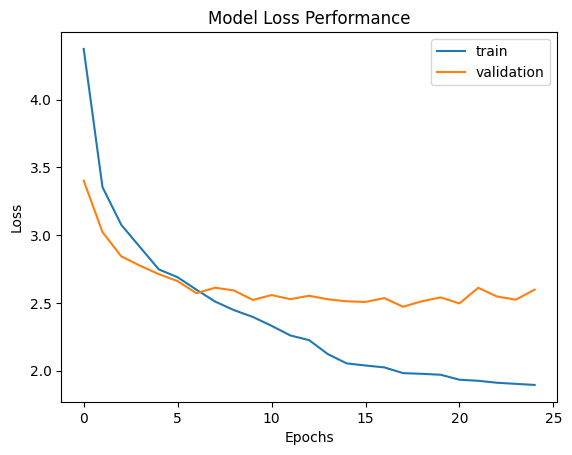

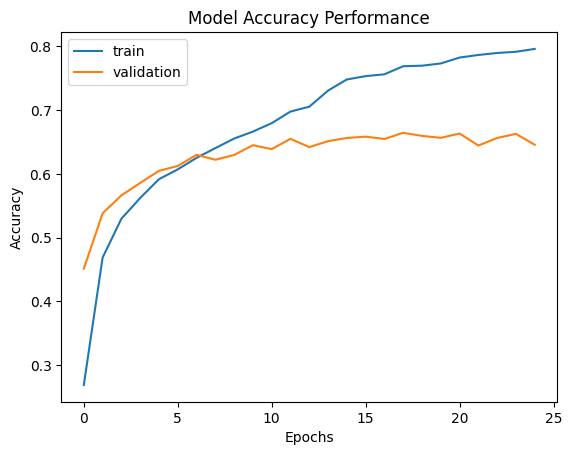

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Model Accuracy Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
def generate_caption_attention(image_path, model, tokenizer, max_length):
    # 1. Get spatial features from the encoder
    # Shape: (1, 7, 7, 2048)
    img_features = get_spatial_features(image_path)
    img_features = np.expand_dims(img_features, axis=0) 

    # 2. Initialize the sequence
    in_text = 'startseq'
    
    # 3. Generate words one by one
    for i in range(max_length):
        # Convert current text to sequence and pad
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        # 4. Predict next word
        # Note: We use the exact input names defined in the Functional API
        predictions = model.predict(
            {"image_spatial_input": img_features, "text_input": sequence}, 
            verbose=0
        )
        
        # Get the index with the highest probability
        idx = np.argmax(predictions)
        
        # Map index to word
        word = tokenizer.index_word.get(idx)
        
        if word is None or word == 'endseq':
            break
            
        in_text += ' ' + word

    # Clean up the output string
    final_caption = in_text.replace('startseq', '').strip()
    return final_caption

Generating report...


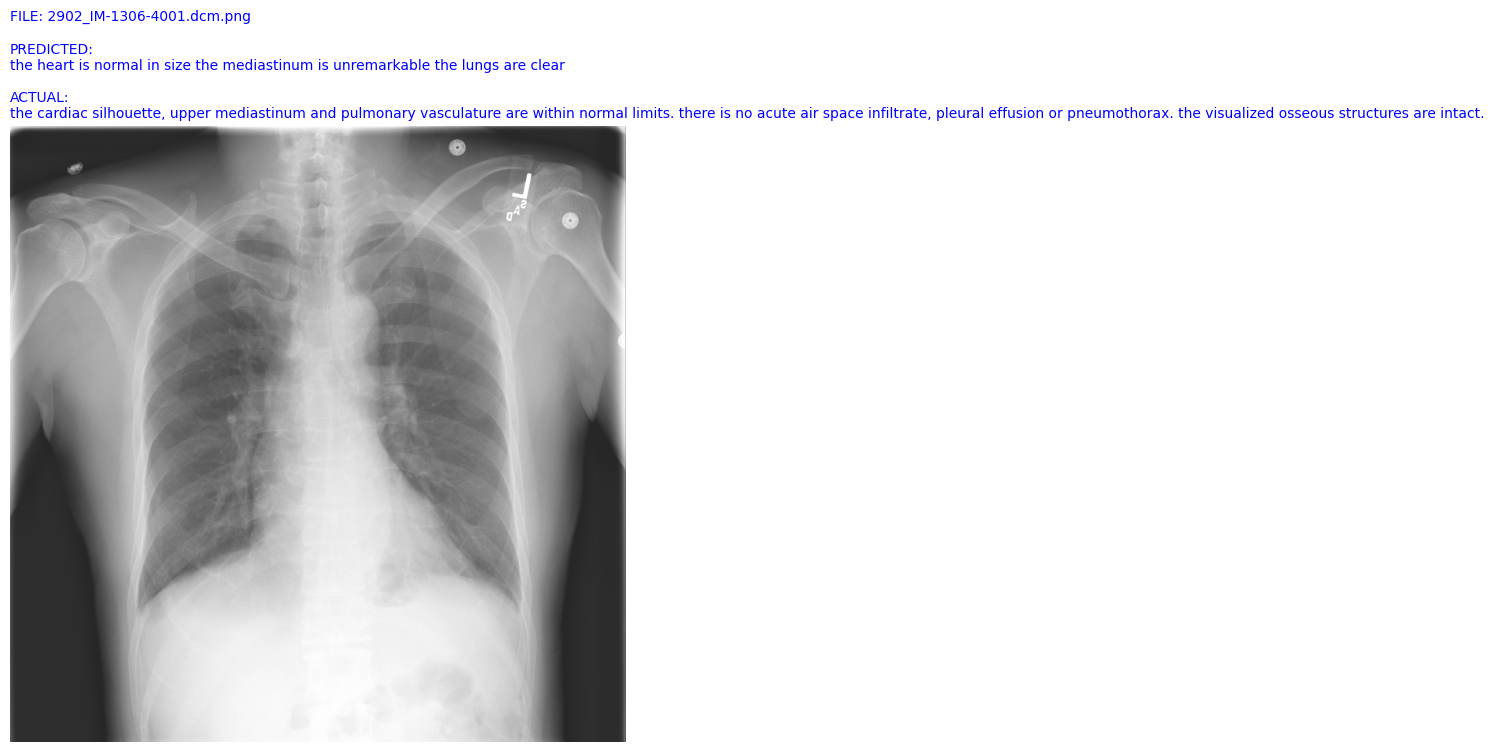

In [20]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# 1. Select a random sample
random_row = df_filtered.sample(1).iloc[0]
sample_filename = random_row['filename']
sample_image_path = image_path_dict[sample_filename]

# 2. Clean up actual findings for comparison
actual_findings = random_row['findings'].replace('startseq ', '').replace(' endseq', '')

# 3. Generate caption using the new Attention logic
print("Generating report...")
generated_caption = generate_caption_attention(sample_image_path, model, tokenizer, MAX_LENGTH)

# 4. Display results
plt.figure(figsize=(10, 8))
img = load_img(sample_image_path)
plt.imshow(img, cmap='gray')

# Formatting the title with a separator
plt.title(f"FILE: {sample_filename}\n\n"
          f"PREDICTED:\n{generated_caption}\n\n"
          f"ACTUAL:\n{actual_findings}", 
          loc='left', fontsize=10, color='blue' if 'normal' in generated_caption else 'red')

plt.axis('off')
plt.show()

# **Export the Models and Tokenizer**

In [21]:
# 1. Save the main Attention-LSTM Decoder
model.save('medical_caption_best.keras')

# 2. Save the Spatial Encoder (crucial for attention)
# We use this instead of the standard ResNet50(pooling='avg')
spatial_encoder.save('spatial_encoder.keras')

# 3. Save the Tokenizer
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("All files exported for Flask deployment.")

All files exported for Flask deployment.
